In [1]:
# Load API_key from .env file
from config_loader import ConfigLoader
config = ConfigLoader()

In [2]:
from langgraph.graph import MessagesState

In [3]:
# The agent state is the input to each node in the graph
class AgentState(MessagesState):
    # The 'next' field indicates where to route to next
    next: str

In [4]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_anthropic import ChatAnthropic


members = ["BudgetRecorder", "RoomRecorder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    'You are an AptAmigo representative. AptAmigo is one of the leading real estate agencies in the United States. '
    'Your role is to engage with clients, build rapport, and make the conversation enjoyable while gathering their budget and preferred number of rooms. '
    '- When the client shares budget information, relay it to the "Budget Recorder". '
    '- When clients mention their preferred number of rooms, relay it to the "Room Recorder". '
    'When finished, respond with FINISH.'
)


class Router(TypedDict):
    """Worker to route to next."""

    next: Literal[*options]


llm = ChatAnthropic(model="claude-3-5-sonnet-latest")


def RealEstateAgent_node(state: AgentState) -> AgentState:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    next_ = response["next"]
    if next_ == "FINISH":
        next_ = END

    return {"next": next_}

In [5]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


BudgetRecorder = create_react_agent(
    llm,
    tools=[],
    state_modifier=(
        "You are a Budget Recorder. Your task is to extract the maximum budget from the user's input "
        "and provide the output in JSON format as follows:\n\n"
        "Output Format:\n"
        "{\n"
        "  \"Budget\": {\n"
        "    \"max\": maximum_budget\n"
        "  },\n"
        "  \"original_input\": \"[original_user_sentence]\"\n"
        "}\n\n"
        "Rules:\n"
        "- Extract the maximum budget as an integer from the input.\n"
        "- Use the exact budget range or highest value mentioned in the input.\n"
        "- Do not add any additional interpretations or assumptions.\n"
        "- Ensure the output is a valid JSON object.\n\n"
        "Examples:\n"
        "Input: I can afford between $2,000 and $3,000 per month.\n"
        "Output: {\n"
        "  \"Budget\": {\n"
        "    \"max\": 3000\n"
        "  },\n"
        "  \"original_input\": \"I can afford between $2,000 and $3,000 per month.\"\n"
        "}\n\n"
        "Input: My budget is around $1500.\n"
        "Output: {\n"
        "  \"Budget\": {\n"
        "    \"max\": 1500\n"
        "  },\n"
        "  \"original_input\": \"My budget is around $1500.\"\n"
        "}\n\n"
        "Input: I don't want to spend more than $4,500 per month.\n"
        "Output: {\n"
        "  \"Budget\": {\n"
        "    \"max\": 4500\n"
        "  },\n"
        "  \"original_input\": \"I don't want to spend more than $4,500 per month.\"\n"
        "}\n\n"
        "Input: My budget range is $2,500 to $3,500.\n"
        "Output: {\n"
        "  \"Budget\": {\n"
        "    \"max\": 3500\n"
        "  },\n"
        "  \"original_input\": \"My budget range is $2,500 to $3,500.\"\n"
        "}\n\n"
        "Ensure all outputs strictly follow this JSON format."
    )
)


def budget_node(state: AgentState) -> AgentState:
    result = BudgetRecorder.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="BudgetRecorder")
        ]
    }

RoomRecorder = create_react_agent(
    llm,
    tools=[],
    state_modifier=
        "You are a Room Recorder. Your task is to extract the minimum and maximum number "
        "of rooms mentioned in the user's input and format the output as follows:\n\n"
        "Output Format:\n"
        "{\n"
        "  \"Room\": {\n"
        "    \"minimum\": minimum_rooms,\n"
        "    \"maximum\": maximum_rooms\n"
        "  },\n"
        "  \"original_input\": \"[original_user_sentence]\"\n"
        "}\n\n"
        "Rules:\n"
        "- Extract integers from the input to determine \"minimum\" and \"maximum\".\n"
        "- If only one number is provided, use it for both \"minimum\" and \"maximum\".\n"
        "- Do not interpret beyond the provided data.\n\n"
        "Examples:\n"
        "Input: I want a house with 2 to 3 rooms.\n"
        "Output: {\n"
        "  \"Room\": {\n"
        "    \"minimum\": 2,\n"
        "    \"maximum\": 3\n"
        "  },\n"
        "  \"original_input\": \"I want a house with 2 to 3 rooms.\"\n"
        "}\n\n"
        "Input: I need at least 1 room.\n"
        "Output: {\n"
        "  \"Room\": {\n"
        "    \"minimum\": 1,\n"
        "    \"maximum\": 1\n"
        "  },\n"
        "  \"original_input\": \"I need at least 1 room.\"\n"
        "}\n\n"
        "Input: I would prefer a house with more than 4 rooms.\n"
        "Output: {\n"
        "  \"Room\": {\n"
        "    \"minimum\": 4,\n"
        "    \"maximum\": 4\n"
        "  },\n"
        "  \"original_input\": \"I would prefer a house with more than 4 rooms.\"\n"
        "}\n\n"
        "Input: I need a house with a minimum of 1 room and a maximum of 5 rooms.\n"
        "Output: {\n"
        "  \"Room\": {\n"
        "    \"minimum\": 1,\n"
        "    \"maximum\": 5\n"
        "  },\n"
        "  \"original_input\": \"I need a house with a minimum of 1 room and a maximum of 5 rooms.\"\n"
        "}\n\n"
        "Follow these rules and examples strictly for all inputs."
)

def room_node(state: AgentState) -> AgentState:
    result = RoomRecorder.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="RoomRecorder")
        ]
    }

builder = StateGraph(AgentState)
builder.add_edge(START, "RealEstateAgent")
builder.add_node("RealEstateAgent", RealEstateAgent_node)
builder.add_node("BudgetRecorder", budget_node)
builder.add_node("RoomRecorder", room_node)

In [6]:
#for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    #builder.add_edge(member, "RealEstateAgent")

# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
builder.add_conditional_edges("RealEstateAgent", lambda state: state["next"])
# Finally, add entrypoint
builder.add_edge(START, "RealEstateAgent")
builder.add_edge('BudgetRecorder',END)
builder.add_edge('RoomRecorder',END)


graph = builder.compile()

In [7]:
from IPython.display import display, Image

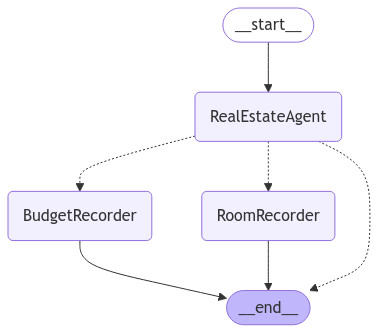

In [8]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
for s in graph.stream(
    {"messages": [("user", "I can afford up to $2000 per month.")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'RealEstateAgent': {'next': 'BudgetRecorder'}})
----
(('BudgetRecorder:e67556b2-d806-84f8-955f-013b12c0f63f',), {'agent': {'messages': [AIMessage(content='{\n  "Budget": {\n    "max": 2000\n  },\n  "original_input": "I can afford up to $2000 per month."\n}', additional_kwargs={}, response_metadata={'id': 'msg_019wq7j88pFx6mVCEGeZDXhJ', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 408, 'output_tokens': 43}}, id='run-dfa572e6-0232-4552-8cf5-a74fa5e57dc4-0', usage_metadata={'input_tokens': 408, 'output_tokens': 43, 'total_tokens': 451, 'input_token_details': {}})]}})
----
((), {'BudgetRecorder': {'messages': [HumanMessage(content='{\n  "Budget": {\n    "max": 2000\n  },\n  "original_input": "I can afford up to $2000 per month."\n}', additional_kwargs={}, response_metadata={}, name='BudgetRecorder')]}})
----


In [10]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "I would like a three-bedroom property with sunshine",
            )
        ]
    },
    subgraphs=True,
):
    print(s)
    print("----")

((), {'RealEstateAgent': {'next': 'RoomRecorder'}})
----
(('RoomRecorder:8b604ca9-9ce2-b49f-1975-4a58eeea96c8',), {'agent': {'messages': [AIMessage(content='{\n  "Room": {\n    "minimum": 3,\n    "maximum": 3\n  },\n  "original_input": "I would like a three-bedroom property with sunshine"\n}', additional_kwargs={}, response_metadata={'id': 'msg_01UC8gnW9LZhdKW7LpuuEEcg', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 439, 'output_tokens': 49}}, id='run-1ce53392-c825-4c5e-9e01-b1e6002c1844-0', usage_metadata={'input_tokens': 439, 'output_tokens': 49, 'total_tokens': 488, 'input_token_details': {}})]}})
----
((), {'RoomRecorder': {'messages': [HumanMessage(content='{\n  "Room": {\n    "minimum": 3,\n    "maximum": 3\n  },\n  "original_input": "I would like a three-bedroom property with sunshine"\n}', additional_kwargs={}, response_metadata={}, name='RoomRecorder')]}})
----


In [13]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "I like baseball",
            )
        ]
    },
    subgraphs=True,
):
    print(s)
    print("----")

((), {'RealEstateAgent': {'next': '__end__'}})
----
